<a href="https://colab.research.google.com/github/DMXMax/covid19/blob/gc_20200315/coviddata.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests,json
import datetime


In [0]:
covidtrackingurl = "https://covidtracking.com/api/states/daily"
response = requests.get(covidtrackingurl)
dfCovidtracking = pd.DataFrame(response.json())
dfCovidtracking.fillna(0, inplace=True)
dfCovidtracking.negative = dfCovidtracking.negative.astype('int64')
dfCovidtracking.positive = dfCovidtracking.positive.astype('int64')
dfCovidtracking.pending = dfCovidtracking.pending.astype('int64')
dfCovidtracking.total = dfCovidtracking.total.astype('int64')
dfCovidtracking.death = dfCovidtracking.death.astype('int64')

dfCovidtracking.date = dfCovidtracking.date.transform(lambda x: pd.to_datetime(datetime.date(x//10000, x%10000//100, x%100
                                          )))


In [0]:
dfWHO = pd.read_csv("https://raw.githubusercontent.com/DMXMax/covid19/master/who/who_data.tsv",
                     sep='\t', index_col='Date')

In [0]:
jhurl = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/"+\
"csse_covid_19_data/csse_covid_19_daily_reports/04-13-2020.csv"

#https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/
#csse_covid_19_data/csse_covid_19_daily_reports/04-01-2020.csv
dfJHUData = pd.read_csv(jhurl, header=0,
                        names=['FIPS', 'city','state', 'country', 'last_update',
                               'lat', 'lon','confirmed', 'dead', 'recovered','active', 'key'])

In [0]:
dfWHO = dfWHO.rename(columns={"Confirmed": "confirmed", "Deaths": "who_deaths"})
dfWHO.index.names=['date']


In [6]:
dfCovidtracking.loc[dfCovidtracking.date==dfCovidtracking.date.max(),\
  ['state', 'positive', 'negative']].sort_values(by='positive', ascending=False).head(10)

,state,positive,negative
37,NY,195031,283326
34,NJ,64584,64885
21,MA,26867,95182
24,MI,25635,57009
41,PA,24199,105593
5,CA,22348,168534
16,IL,22025,83743
20,LA,21016,87075
10,FL,20601,175606
47,TX,13906,119320


In [0]:
gbUSA = dfCovidtracking.groupby(['date'])
gbCA = dfCovidtracking[dfCovidtracking.state=='CA'].groupby(['date'])

dfUSAPos = gbUSA.positive.sum().reset_index().copy()
dfCAPos = gbCA.positive.sum().reset_index().copy()

#This will calculate the percentage each day is of the total. In a flattening, this will be more even
# In a high growth situation, you'll higher percentages at the tail. 
dfUSAPos['PCT']= dfUSAPos.positive/dfUSAPos.max().positive
dfCAPos['PCT']=dfCAPos.positive/dfCAPos.max().positive

In [8]:
dfUSAPos[-7:]

,date,positive,PCT
39,2020-04-07,394156,0.683380
40,2020-04-08,424289,0.735624
41,2020-04-09,458635,0.795173
42,2020-04-10,493252,0.855191
43,2020-04-11,522843,0.906495
44,2020-04-12,551826,0.956746
45,2020-04-13,576774,1.000000


In [9]:
dfCAPos[-7:]

,date,positive,PCT
34,2020-04-07,15865,0.709907
35,2020-04-08,16957,0.758770
36,2020-04-09,18309,0.819268
37,2020-04-10,19472,0.871308
38,2020-04-11,19472,0.871308
39,2020-04-12,21794,0.975210
40,2020-04-13,22348,1.000000


In [10]:
gbUSA.sum()[-5:]

,positive,negative,pending,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,inIcuCumulative,onVentilatorCurrently,onVentilatorCumulative,recovered,death,hospitalized,total,totalTestResults,posNeg,deathIncrease,hospitalizedIncrease,negativeIncrease,positiveIncrease,totalTestResultsIncrease
date,,,,,,,,,,,,,,,,,,,,
2020-04-09,458635,1916720,17622,46676.0,52051.0,12254.0,924.0,5794.0,39.0,24869.0,16424,52051.0,2392977,2375355.0,2375355.0,1877.0,3377.0,128443.0,34346.0,162789.0
2020-04-10,493252,2036030,17435,48468.0,56342.0,12698.0,1185.0,5937.0,41.0,29054.0,18488,56342.0,2546717,2529282.0,2529282.0,2064.0,4291.0,119310.0,34617.0,153927.0
2020-04-11,522843,2142823,16593,51409.0,58549.0,13563.0,1228.0,5978.0,41.0,31631.0,20355,58549.0,2682259,2665666.0,2665666.0,1867.0,2979.0,106793.0,29591.0,136384.0
2020-04-12,551826,2254066,16419,51413.0,61201.0,13917.0,1455.0,5986.0,160.0,34151.0,21919,61201.0,2822311,2805892.0,2805892.0,1564.0,2652.0,111243.0,28983.0,140226.0
2020-04-13,576774,2358232,17159,50968.0,62673.0,13632.0,1628.0,6168.0,210.0,35442.0,23369,62673.0,2952165,2935006.0,2935006.0,1450.0,1472.0,104166.0,24948.0,129114.0


In [11]:
gbCA.sum()[-5:]

,positive,negative,pending,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,inIcuCumulative,onVentilatorCurrently,onVentilatorCumulative,recovered,death,hospitalized,total,totalTestResults,posNeg,deathIncrease,hospitalizedIncrease,negativeIncrease,positiveIncrease,totalTestResultsIncrease
date,,,,,,,,,,,,,,,,,,,,
2020-04-09,18309,145191,14100,2825.0,0.0,1132.0,0.0,0.0,0.0,0.0,492,0.0,177600,163500.0,163500.0,50.0,0.0,17884.0,1352.0,19236.0
2020-04-10,19472,145391,13900,2897.0,0.0,1145.0,0.0,0.0,0.0,0.0,541,0.0,178763,164863.0,164863.0,49.0,0.0,200.0,1163.0,1363.0
2020-04-11,19472,152604,13200,5236.0,0.0,1591.0,0.0,0.0,0.0,0.0,541,0.0,185276,172076.0,172076.0,0.0,0.0,7213.0,0.0,7213.0
2020-04-12,21794,168534,13200,5234.0,0.0,1539.0,0.0,0.0,0.0,0.0,651,0.0,203528,190328.0,190328.0,110.0,0.0,15930.0,2322.0,18252.0
2020-04-13,22348,168534,13200,3015.0,0.0,1178.0,0.0,0.0,0.0,0.0,687,0.0,204082,190882.0,190882.0,36.0,0.0,0.0,554.0,554.0


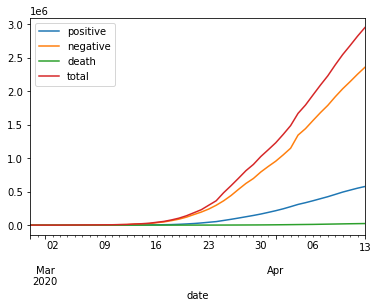

In [12]:
x=gbUSA.sum().loc[:, ['positive', 'negative','death','total']].plot.line()

In [13]:
dfWHO[-14:]

,confirmed,who_deaths
date,,
2020-03-31,140640,2398
2020-04-01,163199,2850
2020-04-02,187302,3846
2020-04-03,213600,4793
2020-04-04,241703,5854
2020-04-05,273808,7020
2020-04-06,307318,8358
2020-04-07,333811,9559
2020-04-08,363321,10845


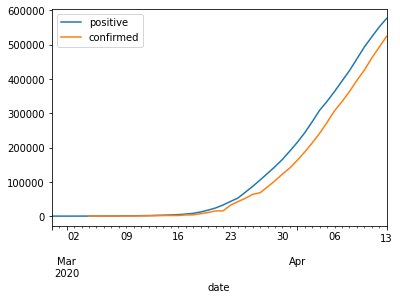

In [14]:
dfResults = gbUSA.sum().join(dfWHO, how='left', rsuffix='_who' )
dfResults.loc[:, ['positive', 'confirmed']].plot.line()

In [15]:
gbCA.sum()[-7:]

,positive,negative,pending,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,inIcuCumulative,onVentilatorCurrently,onVentilatorCumulative,recovered,death,hospitalized,total,totalTestResults,posNeg,deathIncrease,hospitalizedIncrease,negativeIncrease,positiveIncrease,totalTestResultsIncrease
date,,,,,,,,,,,,,,,,,,,,
2020-04-07,15865,115364,14100,2611.0,0.0,1108.0,0.0,0.0,0.0,0.0,374,0.0,145329,131229.0,131229.0,31.0,0.0,12269.0,1529.0,13798.0
2020-04-08,16957,127307,14600,2714.0,0.0,1154.0,0.0,0.0,0.0,0.0,442,0.0,158864,144264.0,144264.0,68.0,0.0,11943.0,1092.0,13035.0
2020-04-09,18309,145191,14100,2825.0,0.0,1132.0,0.0,0.0,0.0,0.0,492,0.0,177600,163500.0,163500.0,50.0,0.0,17884.0,1352.0,19236.0
2020-04-10,19472,145391,13900,2897.0,0.0,1145.0,0.0,0.0,0.0,0.0,541,0.0,178763,164863.0,164863.0,49.0,0.0,200.0,1163.0,1363.0
2020-04-11,19472,152604,13200,5236.0,0.0,1591.0,0.0,0.0,0.0,0.0,541,0.0,185276,172076.0,172076.0,0.0,0.0,7213.0,0.0,7213.0
2020-04-12,21794,168534,13200,5234.0,0.0,1539.0,0.0,0.0,0.0,0.0,651,0.0,203528,190328.0,190328.0,110.0,0.0,15930.0,2322.0,18252.0
2020-04-13,22348,168534,13200,3015.0,0.0,1178.0,0.0,0.0,0.0,0.0,687,0.0,204082,190882.0,190882.0,36.0,0.0,0.0,554.0,554.0


In [16]:
dfJHUData[dfJHUData.country=='US'][['confirmed', 'dead']].sum()

confirmed    580619
dead          23529
dtype: int64

In [17]:
dfJHUData[(dfJHUData.country=='US')&(dfJHUData.state=='California')][['confirmed', 'dead']].sum()

confirmed    23931
dead           715
dtype: int64

In [0]:
dfJHUUS = dfJHUData[dfJHUData.country=='US']
gbJHUByState= dfJHUUS.groupby(by='state')
gbJHUByCountry = dfJHUData.groupby(by='country')

In [19]:
gbJHUByCountry.confirmed.sum().sort_values(ascending=False).head(10)

country
US                580619
Spain             170099
Italy             159516
France            137875
Germany           130072
United Kingdom     89570
China              83213
Iran               73303
Turkey             61049
Belgium            30589
Name: confirmed, dtype: int64

In [0]:
dfData = dfCovidtracking.groupby('date')

In [0]:
dfStateTotal = dfCovidtracking[['state', 'positive']].groupby(by='state').max() \
.rename(columns={'positive':'current_total'})


In [0]:
dfState = dfCovidtracking[['date','state','positive']].set_index('state') \
  .join(dfStateTotal)

In [0]:
dfState['pct']=dfState.positive/dfState.current_total

In [24]:
dfState.loc['FL'].head(7)

,date,positive,current_total,pct
state,,,,
FL,2020-04-13,20601,20601,1.000000
FL,2020-04-12,19355,20601,0.939517
FL,2020-04-11,18494,20601,0.897723
FL,2020-04-10,17531,20601,0.850978
FL,2020-04-09,16364,20601,0.794330
FL,2020-04-08,15455,20601,0.750206
FL,2020-04-07,14747,20601,0.715839


In [0]:
res = dfState.reset_index().pivot(index = 'date', columns='state', values='pct').fillna(0)

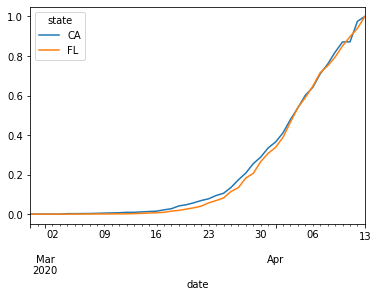

In [26]:
x = res.loc[:, ['CA','FL']].plot.line()

In [0]:
dfNYTesting = dfCovidtracking.loc[dfCovidtracking.state=='NY', ['date', 'negative']].set_index('date')

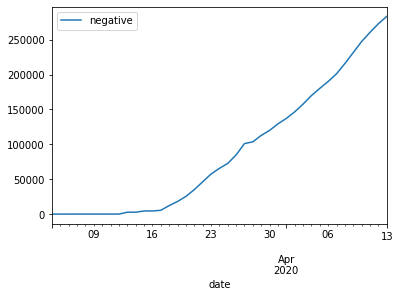

In [28]:
x = dfNYTesting.plot.line()

In [29]:
dfDates = dfState.reset_index().copy()
dfDates[(dfDates.state.isin(['FL']))].head(10)

,state,date,positive,current_total,pct
384,FL,2020-04-13,20601,20601,1.000000
385,FL,2020-04-12,19355,20601,0.939517
386,FL,2020-04-11,18494,20601,0.897723
387,FL,2020-04-10,17531,20601,0.850978
388,FL,2020-04-09,16364,20601,0.794330
389,FL,2020-04-08,15455,20601,0.750206
390,FL,2020-04-07,14747,20601,0.715839
391,FL,2020-04-06,13324,20601,0.646765
392,FL,2020-04-05,12151,20601,0.589826
393,FL,2020-04-04,11111,20601,0.539343


In [30]:
datecutoff = dfDates.date.max()-datetime.timedelta(days=3)
dfDates[(dfDates.date == datecutoff) & (dfDates.pct < .7)].sort_values(by='pct')


,state,date,positive,current_total,pct
1742,SD,2020-04-10,536,868,0.617512
1657,RI,2020-04-10,2015,2976,0.677083


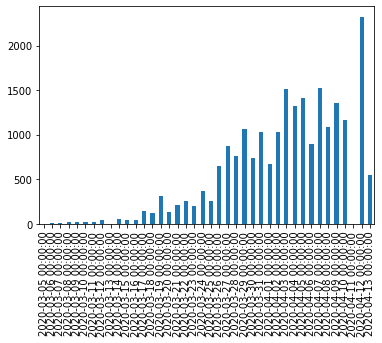

In [31]:
state = 'CA'
dfState = dfCovidtracking[dfCovidtracking.state==state].sort_values(by='date')
vals = dfState.positive.values

x=pd.Series([y-x for x,y in zip(vals,vals[1:])], \
          index = dfCovidtracking[dfCovidtracking.state==state]\
          .sort_values(by='date').date.values[1:] ) \
          .plot.bar()



# Added State Data

In [0]:
data_url = "https://www2.census.gov/programs-surveys/popest/datasets/2010-2019/national/totals/nst-est2019-alldata.csv"


In [0]:
dfUSPop = pd.read_csv(data_url)

In [34]:
us_pop = dfUSPop.loc[0].POPESTIMATE2019 #Estimate from Wikipedia
res = dfCovidtracking.loc[dfCovidtracking.date==dfCovidtracking.date.max(), ['positive', 'negative', 'pending','death', 'total']].sum()
print(res)
print(f"Current Infection Rate {res.positive/res.total*100:2f}%")
print(f"Percentage of US affected: {(res.positive+res.death)/us_pop*100:2f}%")
print(f"Percentage of US tested/affected: {(res.negative+res.positive+res.death)/us_pop*100:2f}%")

positive     576774
negative    2358232
pending       17159
death         23369
total       2952165
dtype: int64
Current Infection Rate 19.537323%
Percentage of US affected: 0.182837%
Percentage of US tested/affected: 0.901285%


In [0]:
!if [ ! -d "loc" ]; then \
git clone https://gist.github.com/rogerallen/1583593 --depth=1 --quiet loc; \
fi
import sys
sys.path.append("loc")




In [0]:
import us_state_abbrev as us_abbr


In [0]:
dfStatePop = dfUSPop[dfUSPop.STATE != 0].copy()

In [0]:
dfStatePop['ABBR']=dfStatePop.NAME.apply(lambda x: us_abbr.us_state_abbrev[x])

In [0]:
dfStatePop = dfStatePop.loc[:, ['ABBR', 'POPESTIMATE2019']]
dfStatePop.set_index('ABBR', inplace=True)

In [0]:
dfStateCovid = dfCovidtracking.loc[dfCovidtracking.date==dfCovidtracking.date.max()].set_index('state')

In [0]:
dfStateJoin = dfStateCovid.join(dfStatePop)

In [42]:
pd.DataFrame([(dfStateJoin.positive / dfStateJoin.POPESTIMATE2019)*100, \
              (dfStateJoin.negative / dfStateJoin.POPESTIMATE2019)*100],\
             index=['state_pos_pop','state_test_pop'] ).T.sort_values(by="state_pos_pop", ascending=False)[:25]

,state_pos_pop,state_test_pop
state,,
NY,1.002547,1.456422
NJ,0.727118,0.730507
LA,0.452074,1.873066
MA,0.389800,1.380950
CT,0.375313,0.867476
RI,0.280924,1.669403
DC,0.277011,1.272265
MI,0.256687,0.570840
PA,0.189025,0.824817
